In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.linear_model as lm
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import datetime

In [2]:
# !curl https://raw.githubusercontent.com/JieYingWu/COVID-19_US_County-level_Summaries/master/data/counties.csv  -o ../data/raw/counties_06-19.csv
# !curl https://raw.githubusercontent.com/JieYingWu/COVID-19_US_County-level_Summaries/master/data/deaths_timeseries.csv -o ../data/raw/time_series_covid19_deaths_US_06-19.csv
# !curl https://opendata.arcgis.com/datasets/6ac5e325468c4cb9b905f1728d6fbf0f_0.csv?outSR=%7B%22latestWkid%22%3A3857%2C%22wkid%22%3A102100%7D -o ../data/raw/hospitals.csv
# !curl https://raw.githubusercontent.com/descarteslabs/DL-COVID-19/master/DL-us-m50.csv -o ../data/raw/DL-us-m50.csv
# !curl https://raw.githubusercontent.com/descarteslabs/DL-COVID-19/master/DL-us-m50_index.csv -o ../data/raw/DL-us-m50_index.csv
# !curl https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv -o ../data/raw/time_series_covid19_deaths_US_05-22.csv
# !curl https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv?cachebust=694ae9957380f150 -o ../data/raw/google_mobility_report_06-14-20.csv
# !curl https://raw.githubusercontent.com/HopkinsIDD/hit-covid/master/data/hit-covid-longdata.csv -o ../data/raw/hit_covid_interventions_06-26-20.csv
# !curl https://raw.githubusercontent.com/Keystone-Strategy/covid19-intervention-data/master/complete_npis_raw_policies.csv -o ../data/raw/complete_npis_inherited_policies_keystone_06_26.csv # have to delete first cell/ttitle
# !curl https://raw.githubusercontent.com/COVID19StatePolicy/SocialDistancing/master/data/USstatesCov19distancingpolicy.csv -o ../data/raw/USstatesCov19distancingpolicy_07_01.csv
# !curl https://data.cms.gov/resource/s2uc-8wxp.csv -o ../data/raw/longtermcare_deaths_07_08.csv

In [3]:
hospitals = pd.read_csv('../data/raw/hospitals.csv')
hospitals.columns

Index(['FID', 'ID', 'NAME', 'ADDRESS', 'CITY', 'STATE', 'ZIP', 'ZIP4',
       'TELEPHONE', 'TYPE', 'STATUS', 'POPULATION', 'COUNTY', 'COUNTYFIPS',
       'COUNTRY', 'LATITUDE', 'LONGITUDE', 'NAICS_CODE', 'NAICS_DESC',
       'SOURCE', 'SOURCEDATE', 'VAL_METHOD', 'VAL_DATE', 'WEBSITE', 'STATE_ID',
       'ALT_NAME', 'ST_FIPS', 'OWNER', 'TTL_STAFF', 'BEDS', 'TRAUMA',
       'HELIPAD'],
      dtype='object')

## Pull Hospital Data

### Long-term Care Hospitals

In [4]:
longterm_all = pd.read_csv('../data/raw/Long-_Term_Care_Hospital_-_General_Information.csv')
longterm_all['Long-term beds'] = longterm_all['Total Number of Beds']
longterm_all = longterm_all.drop(columns='Total Number of Beds')
fipscodes = pd.read_csv('../data/raw/countyfipstool2019.csv').filter(['sab', 'cname', 'fips'])
longterm_all = fipscodes.merge(longterm_all, left_on=['sab', 'cname'], right_on=['State', 'County Name'])
longterm_all['FIPS'] = longterm_all['fips']
longterm_all = longterm_all.drop(columns=['sab', 'cname', 'fips', 'State', 'County Name'])
longterm = longterm_all.filter(['FIPS', 'Long-term beds', 'State', 'County Name'])
longterm = longterm.dropna()
longterm.head()

,FIPS,Long-term beds
0,1015,38
1,1069,35
2,1073,38
3,1073,45
4,1083,31


In [5]:
fips_groups =longterm.groupby("FIPS")

LT_hosp_data = pd.DataFrame(columns=['FIPS', 'Longterm HospCt', 'Longterm Beds'])
for fips_code, grp in fips_groups:
    LT_hosp_data = LT_hosp_data.append({'FIPS': fips_code, 'Longterm HospCt': len(grp), 'Longterm Beds': sum(grp['Long-term beds'])}, ignore_index=True)   

LT_hosp_data.head()

,FIPS,Longterm HospCt,Longterm Beds
0,1015,1,38
1,1069,1,35
2,1073,2,83
3,1083,1,31
4,1097,1,22


### Nursing Homes

In [6]:
nursing_homes = pd.read_csv('../data/raw/Nursing_Homes.csv').filter(['COUNTYFIPS','BEDS', 'STATUS'])
nursing_homes = nursing_homes[nursing_homes['STATUS'] == 'OPEN']
nursing_homes = nursing_homes.drop(columns='STATUS')
nursing_homes.head()

,COUNTYFIPS,BEDS
0,54019,58
1,51153,107
2,37051,170
3,25017,-999
4,55035,6


In [7]:
nursing = pd.DataFrame(columns=['FIPS', 'NursingCt', 'NursingBeds'])
nursing_fips = nursing_homes.groupby('COUNTYFIPS')
for fips, grp in nursing_fips:
    nursing = nursing.append({'FIPS': fips, 'NursingCt': len(grp), 'NursingBeds': sum(grp['BEDS'])}, ignore_index=True)
nursing.head()

,FIPS,NursingCt,NursingBeds
0,1001,6,315
1,1003,25,1816
2,1005,3,212
3,1007,1,131
4,1009,9,367


### General Hospitals

In [8]:
# Created by Michael
hospitals = pd.read_csv('../data/raw/hospitals.csv')[['TYPE', 'STATUS', 'COUNTYFIPS', 'BEDS', 'STATE', 'COUNTY']]
print(set(hospitals["TYPE"]))
hospitals = hospitals[hospitals["STATUS"] == 'OPEN']
hospitals = hospitals[hospitals["TYPE"] == 'GENERAL ACUTE CARE']
hospitals = hospitals[hospitals["BEDS"].astype(str).astype(int) > 0]
hospitals["FIPS"] = hospitals["COUNTYFIPS"]
hospitals = hospitals[hospitals["FIPS"] != 'NOT AVAILABLE']
hospitals = hospitals.drop(["COUNTYFIPS", "STATUS"], axis=1)
hospitals["FIPS"] = hospitals["FIPS"].astype(str).astype(int)

fips_groups = hospitals.groupby("FIPS")

hosp_data = pd.DataFrame(columns=['FIPS', 'HospCt', 'Beds'])
for fips_code, grp in fips_groups:
    hosp_data = hosp_data.append({'FIPS': fips_code, 'HospCt': len(grp), 'Beds': sum(grp["BEDS"])}, ignore_index=True)   

hosp_data.head()

{'REHABILITATION', 'MILITARY', 'GENERAL ACUTE CARE', 'CHILDREN', 'CHRONIC DISEASE', 'SPECIAL', 'LONG TERM CARE', 'CRITICAL ACCESS', 'PSYCHIATRIC', 'WOMEN'}


,FIPS,HospCt,Beds
0,1001,1,85
1,1003,3,332
2,1005,1,74
3,1007,1,35
4,1011,1,61


## County Data

In [9]:
counties = pd.read_csv('../data/raw/counties_06-19.csv')
# print(counties.columns.values)
counties = counties.dropna(how='any')
# counties['FIPS'] = counties['FIPS'] .astype('int')
counties = counties.set_index('FIPS')
# print(counties.where(counties['FIPS'] == 36061))
# print(counties.loc[6037,], '\n')
# counties = counties.filter(['FIPS', 'Rural-urban_Continuum Code_2013', 'Density per square mile of land area - Population'])
counties = counties.filter(['FIPS',  'Density per square mile of land area - Population', 'Rural-urban_Continuum Code_2013', \
                            'Percent of adults with less than a high school diploma 2014-18',\
                            "Percent of adults with a bachelor's degree or higher 2014-18", 'Unemployment_rate_2018', \
                            'Med_HH_Income_Percent_of_State_Total_2018', 'Jan Temp AVG / F', 'Feb Temp AVG / F', 'Mar Temp AVG / F', 'Apr Temp AVG / F', 'May Temp AVG / F', \
                            'Jun Temp AVG / F', 'Jul Temp AVG / F', 'Aug Temp AVG / F', 'Sep Temp AVG / F', 'Oct Temp AVG / F', 'Nov Temp AVG / F', 'Dec Temp AVG / F', 'Total_age65plus',  'Total households!!Average household size',\
                            'SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Nursery school preschool',\
                            'SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Kindergarten',\
                            'SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Elementary school (grades 1-8)',\
                            'SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!High school (grades 9-12)',\
                            'SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!College or graduate school', 'POP_ESTIMATE_2018', \
                            'H_MALE', 'H_FEMALE', 'BA_MALE', 'BA_FEMALE'])
print(counties.shape)
counties = counties.dropna()
print(counties.shape)
counties = counties.merge(hosp_data, how='left', left_on='FIPS', right_on='FIPS')
# counties = counties.merge(LT_hosp_data, how='left',  left_on='FIPS', right_on='FIPS')
counties = counties.merge(nursing, how='left', left_on='FIPS', right_on='FIPS')
print("test:", counties.shape)
counties = counties.fillna(value=0)
print(counties.shape)
counties = counties.drop(columns=['Beds'])
# counties = counties.drop(columns=['Longterm Beds'])
counties = counties.drop(columns=['NursingBeds'])

counties['Hispanic Population'] = counties['H_MALE'] + counties['H_FEMALE']
counties = counties.drop(columns=['H_FEMALE', 'H_MALE'])
counties['Black Population'] = counties['BA_MALE'] + counties['BA_FEMALE']
counties = counties.drop(columns=['BA_FEMALE', 'BA_MALE'])
print(counties.shape)
counties.head()

(717, 30)
(717, 30)
test: (717, 35)
(717, 35)
(717, 31)


,FIPS,Density per square mile of land area - Population,Rural-urban_Continuum Code_2013,Percent of adults with less than a high school diploma 2014-18,Percent of adults with a bachelor's degree or higher 2014-18,Unemployment_rate_2018,Med_HH_Income_Percent_of_State_Total_2018,Jan Temp AVG / F,Feb Temp AVG / F,Mar Temp AVG / F,...,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Nursery school preschool,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Kindergarten,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Elementary school (grades 1-8),SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!High school (grades 9-12),SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!College or graduate school,POP_ESTIMATE_2018,HospCt,NursingCt,Hispanic Population,Black Population
0,1003,114.6,3.0,9.7,31.3,3.6,115.5,52.0,62.0,59.7,...,3065.0,1449.0,23254.0,11209.0,6503.0,218022,3,25,10131.0,19492.0
1,1015,195.7,3.0,15.9,18.0,4.7,91.0,44.2,52.6,53.0,...,1563.0,1484.0,11224.0,4972.0,6890.0,114277,3,16,4469.0,24153.0
2,1043,109.4,4.0,18.2,13.7,3.3,91.8,43.2,51.8,51.2,...,734.0,547.0,8867.0,4571.0,3024.0,83442,1,11,3699.0,1116.0
3,1049,91.5,6.0,25.9,12.7,3.8,79.2,41.5,49.9,49.8,...,386.0,700.0,8313.0,4354.0,1654.0,71385,1,7,10595.0,1325.0
4,1051,128.2,2.0,13.6,24.5,3.4,121.0,46.7,57.6,55.7,...,1057.0,546.0,7403.0,5128.0,4022.0,81887,2,7,2467.0,17570.0


## Deaths Data

In [10]:
deaths_t_series = pd.read_csv('../data/raw/time_series_covid19_deaths_US_06-19.csv')
# print(filtered.loc[36061,])
# print(deaths.columns.values)
# deaths_t_series = deaths_t_series.drop(['UID', 'iso2', 'iso3', 'code3', 'Admin2', 'Population', 'Province_State', 'Country_Region', 'Lat', 'Long_', 'Combined_Key'], axis=1)
deaths_t_series = deaths_t_series.drop(['Combined_Key'], axis=1)

# deaths = deaths.dropna()
# deaths = deaths.set_index('FIPS')

deaths_t_series.head()

,FIPS,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,...,6/6/20,6/7/20,6/8/20,6/9/20,6/10/20,6/11/20,6/12/20,6/13/20,6/14/20,6/15/20
0,1001,0,0,0,0,0,0,0,0,0,...,5,5,5,5,6,6,6,6,6,6
1,1003,0,0,0,0,0,0,0,0,0,...,9,9,9,9,9,9,9,9,9,9
2,1005,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
3,1007,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
4,1009,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1


In [11]:
# total_deaths = pd.DataFrame(deaths.sum(axis=1), columns=['deaths'])
# total_deaths.columns = ['FIPS', 'deaths']
death_data = pd.DataFrame(columns=['FIPS', 'Deaths', 'Outbreak_date'])
dates = deaths_t_series.columns[1:]
death_thresh = 3
n_days = 21

# Get all existing data n_days from the death_thresh death.
for i in range(len(deaths_t_series)):
    county = deaths_t_series.iloc[i]
    outbreak_date = None

    # Iterate through dates to find first date with deaths >= death thresh
    for j in range(len(dates)):
        if county[dates[j]] >= death_thresh: 
            outbreak_date = dates[j]

            # See if this happened n_days or more before current day
            try:
                n_days_later = dates[j+n_days]

                # Make sure the data is bug-free
                bad_data=False
                for k in range(n_days):
                    if county[n_days_later] < county[dates[j+k]]:
                        bad_data=True
                if not bad_data:
                    outbreak_date = datetime.datetime.strptime(outbreak_date, '%m/%d/%y')
                    death_data = death_data.append({'FIPS': county['FIPS'], 'Deaths':county[n_days_later], 'Outbreak_date':outbreak_date}, ignore_index=True)
                break

            except:
                continue
#                 break
                
death_data.head()

,FIPS,Deaths,Outbreak_date
0,1001,4,2020-04-27
1,1003,6,2020-04-20
2,1011,8,2020-05-25
3,1013,16,2020-05-08
4,1015,3,2020-04-20


In [12]:
combined_data = counties.merge(death_data, left_on='FIPS', right_on='FIPS')
combined_data = combined_data.dropna()
combined_data.set_index('FIPS', inplace=True)
print(combined_data.shape)
combined_data.head()

(565, 32)


,Density per square mile of land area - Population,Rural-urban_Continuum Code_2013,Percent of adults with less than a high school diploma 2014-18,Percent of adults with a bachelor's degree or higher 2014-18,Unemployment_rate_2018,Med_HH_Income_Percent_of_State_Total_2018,Jan Temp AVG / F,Feb Temp AVG / F,Mar Temp AVG / F,Apr Temp AVG / F,...,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Elementary school (grades 1-8),SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!High school (grades 9-12),SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!College or graduate school,POP_ESTIMATE_2018,HospCt,NursingCt,Hispanic Population,Black Population,Deaths,Outbreak_date
FIPS,,,,,,,,,,,,,,,,,,,,,
1003,114.6,3.0,9.7,31.3,3.6,115.5,52.0,62.0,59.7,66.0,...,23254.0,11209.0,6503.0,218022,3,25,10131.0,19492.0,6,2020-04-20
1015,195.7,3.0,15.9,18.0,4.7,91.0,44.2,52.6,53.0,63.0,...,11224.0,4972.0,6890.0,114277,3,16,4469.0,24153.0,3,2020-04-20
1049,91.5,6.0,25.9,12.7,3.8,79.2,41.5,49.9,49.8,60.7,...,8313.0,4354.0,1654.0,71385,1,7,10595.0,1325.0,5,2020-05-19
1051,128.2,2.0,13.6,24.5,3.4,121.0,46.7,57.6,55.7,64.4,...,7403.0,5128.0,4022.0,81887,2,7,2467.0,17570.0,7,2020-05-04
1055,195.2,3.0,15.5,17.7,4.1,90.0,43.9,51.5,52.2,62.8,...,10215.0,4628.0,4019.0,102501,2,15,4116.0,16094.0,8,2020-04-04


## Longterm Care Deaths

In [13]:
# print(longterm_all.loc[0, ])
# print(longterm_all.shape)
# longterm_all.head()

In [14]:
# longterm_deaths = pd.read_csv('../data/raw/longtermcare_deaths_07_08.csv')
# longterm_deaths['CMS Certification Number (CCN)'] = np.nan
# print(longterm_deaths.loc[0, 'federal_provider_number'])
# print(int(longterm_deaths.loc[0, 'federal_provider_number']))
# for i in longterm_deaths.index:
#     try: 
#         longterm_deaths.loc[i, 'CMS Certification Number (CCN)'] = int(longterm_deaths.loc[i, 'federal_provider_number'])
#     except:
#         longterm_deaths.drop(index=i, inplace=True)
#         continue
# # longterm_deaths = longterm_deaths.dropna()        
# longterm_deaths['CMS Certification Number (CCN)'] = longterm_deaths['CMS Certification Number (CCN)'].astype('int64')
# print(longterm_deaths.shape)
# longterm_deaths.head(15)

In [15]:
# for i in longterm_deaths['CMS Certification Number (CCN)'].values: 
#     if i in longterm_all['CMS Certification Number (CCN)'].values:
#         print(i)
# print(longterm_all['CMS Certification Number (CCN)'].values)

In [16]:
# print(longterm_deaths['CMS Certification Number (CCN)'].values)

In [17]:
# print(longterm_deaths['provider_name'].values)

In [18]:

# longterm_all = longterm_all.merge(longterm_deaths, left_on=['CMS Certification Number (CCN)'], right_on=['CMS Certification Number (CCN)'], how='left')
# print(longterm_all.shape)
# longterm_all = longterm_all.dropna()
# print(longterm_all.shape)
# longterm_all.head()

## Drop Outlier Counties

In [19]:
# combined_data = combined_data.drop(index=36061)
# combined_data = combined_data.drop(index=17031)
# combined_data = combined_data.drop(index=26163)
# combined_data = combined_data.drop(index=36059)
# combined_data = combined_data.drop(index=6037)
# combined_data = combined_data.drop(index=34013)
#36061(NY) 17031, 26163, 36059, 6037 (LA)
# combined_data.rename(columns={'Rural-urban_Continuum Code_2013': 'RUCC'}, inplace=True)
print(np.max(combined_data['Rural-urban_Continuum Code_2013']))
print(np.min(combined_data['Rural-urban_Continuum Code_2013']))
filter_high = combined_data['Rural-urban_Continuum Code_2013'] > 8
inidices_high = combined_data.where(filter_high).dropna().index.to_numpy()
filter_low = combined_data['Rural-urban_Continuum Code_2013'] < 0
inidices_low = combined_data.where(filter_low).dropna().index.to_numpy()
# print(filter.index.to_numpy().shape)
combined_data = combined_data.drop(index=inidices_low, axis=0)
combined_data = combined_data.drop(index=inidices_high, axis=0)
# combined_data.set_index('FIPS', inplace=True)
combined_data.head()

6.0
1.0


,Density per square mile of land area - Population,Rural-urban_Continuum Code_2013,Percent of adults with less than a high school diploma 2014-18,Percent of adults with a bachelor's degree or higher 2014-18,Unemployment_rate_2018,Med_HH_Income_Percent_of_State_Total_2018,Jan Temp AVG / F,Feb Temp AVG / F,Mar Temp AVG / F,Apr Temp AVG / F,...,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Elementary school (grades 1-8),SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!High school (grades 9-12),SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!College or graduate school,POP_ESTIMATE_2018,HospCt,NursingCt,Hispanic Population,Black Population,Deaths,Outbreak_date
FIPS,,,,,,,,,,,,,,,,,,,,,
1003,114.6,3.0,9.7,31.3,3.6,115.5,52.0,62.0,59.7,66.0,...,23254.0,11209.0,6503.0,218022,3,25,10131.0,19492.0,6,2020-04-20
1015,195.7,3.0,15.9,18.0,4.7,91.0,44.2,52.6,53.0,63.0,...,11224.0,4972.0,6890.0,114277,3,16,4469.0,24153.0,3,2020-04-20
1049,91.5,6.0,25.9,12.7,3.8,79.2,41.5,49.9,49.8,60.7,...,8313.0,4354.0,1654.0,71385,1,7,10595.0,1325.0,5,2020-05-19
1051,128.2,2.0,13.6,24.5,3.4,121.0,46.7,57.6,55.7,64.4,...,7403.0,5128.0,4022.0,81887,2,7,2467.0,17570.0,7,2020-05-04
1055,195.2,3.0,15.5,17.7,4.1,90.0,43.9,51.5,52.2,62.8,...,10215.0,4628.0,4019.0,102501,2,15,4116.0,16094.0,8,2020-04-04


In [20]:
combined_data.head()

,Density per square mile of land area - Population,Rural-urban_Continuum Code_2013,Percent of adults with less than a high school diploma 2014-18,Percent of adults with a bachelor's degree or higher 2014-18,Unemployment_rate_2018,Med_HH_Income_Percent_of_State_Total_2018,Jan Temp AVG / F,Feb Temp AVG / F,Mar Temp AVG / F,Apr Temp AVG / F,...,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Elementary school (grades 1-8),SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!High school (grades 9-12),SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!College or graduate school,POP_ESTIMATE_2018,HospCt,NursingCt,Hispanic Population,Black Population,Deaths,Outbreak_date
FIPS,,,,,,,,,,,,,,,,,,,,,
1003,114.6,3.0,9.7,31.3,3.6,115.5,52.0,62.0,59.7,66.0,...,23254.0,11209.0,6503.0,218022,3,25,10131.0,19492.0,6,2020-04-20
1015,195.7,3.0,15.9,18.0,4.7,91.0,44.2,52.6,53.0,63.0,...,11224.0,4972.0,6890.0,114277,3,16,4469.0,24153.0,3,2020-04-20
1049,91.5,6.0,25.9,12.7,3.8,79.2,41.5,49.9,49.8,60.7,...,8313.0,4354.0,1654.0,71385,1,7,10595.0,1325.0,5,2020-05-19
1051,128.2,2.0,13.6,24.5,3.4,121.0,46.7,57.6,55.7,64.4,...,7403.0,5128.0,4022.0,81887,2,7,2467.0,17570.0,7,2020-05-04
1055,195.2,3.0,15.5,17.7,4.1,90.0,43.9,51.5,52.2,62.8,...,10215.0,4628.0,4019.0,102501,2,15,4116.0,16094.0,8,2020-04-04


## Mobility Data

In [21]:
dl_index = pd.read_csv('../data/raw/DL-us-m50_index_05-22.csv')
dl_abs_movement = pd.read_csv('../data/raw/DL-us-m50_05-22.csv')
dl_index = dl_index.dropna()
dl_abs_movement = dl_abs_movement.dropna()
dl = dl_index.merge(dl_abs_movement, on='fips')
print(dl.head())

baseline1 = pd.DataFrame(dl['2020-03-01_y'] / (.01 * dl['2020-03-01_x']))
baseline2 = pd.DataFrame(dl['2020-03-02_y'] / (.01 * dl['2020-03-02_x']))
baseline3 = pd.DataFrame(dl['2020-03-03_y'] / (.01 * dl['2020-03-03_x']))
baselines = pd.concat((baseline1, baseline2, baseline3), axis=1)

pd.set_option('display.max_rows', None)
dl['baseline m50 mobility'] = baselines.mean(axis=1)
baseline_data = dl[['baseline m50 mobility', 'fips']]
baseline_data['FIPS'] = baseline_data['fips']
baseline_data = baseline_data.drop(['fips'], axis=1)
baseline_data.set_index('FIPS', inplace=True)
baseline_data.head()

  country_code_x  admin_level_x admin1_x        admin2_x    fips  \
0             US              2  Alabama  Autauga County  1001.0   
1             US              2  Alabama  Baldwin County  1003.0   
2             US              2  Alabama  Barbour County  1005.0   
3             US              2  Alabama     Bibb County  1007.0   
4             US              2  Alabama   Blount County  1009.0   

   2020-03-01_x  2020-03-02_x  2020-03-03_x  2020-03-04_x  2020-03-05_x  ...  \
0          49.0         100.0          95.0          95.0         100.0  ...   
1          81.0         100.0          95.0          90.0         102.0  ...   
2          90.0         107.0         100.0          70.0          88.0  ...   
3          53.0          95.0         100.0          94.0         111.0  ...   
4          68.0          96.0         100.0          99.0         101.0  ...   

   2020-05-10_y  2020-05-11_y  2020-05-12_y  2020-05-13_y  2020-05-14_y  \
0         5.914         8.067      

/Users/beatrizmedeiros/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


,baseline m50 mobility
FIPS,
1001.0,14.621123
1003.0,12.067112
1005.0,9.297363
1007.0,24.332641
1009.0,23.362889


In [22]:
# combined_data = baseline_data.merge(combined_data, left_on='FIPS', right_on='FIPS')
# combined_data.head()

## Safegraph Mobility data 

In [23]:
combined_data.to_csv('../data/intermediates/pre_acpca.csv')

In [24]:
sg_mobility = pd.read_csv('../data/processed/safegraph_mobility_avgs.csv')

In [25]:
# safegraph = pd.read_csv('../data/processed/od_mobility_baseline.csv')
# safegraph = safegraph.drop(columns='in_movement')

In [26]:
# combined_data = safegraph.merge(combined_data, left_on='FIPS', right_on='FIPS')
# combined_data = combined_data.set_index('FIPS')

In [27]:
# safegraph_inter = pd.read_csv('../data/processed/od_inter_mobilities_05-20.csv')
# column_change = {}
# for col in safegraph_inter.columns[1:]: 
# #     print(col)
#     date = datetime.datetime.strptime(col+ '-20', '%m-%d-%y')
#     column_change[col] = date.date()
# safegraph_inter = safegraph_inter.rename(columns=column_change)
# print(safegraph_inter.columns[2])
# # print(combined_data.loc[1003, 'Outbreak_date'])
# safegraph_inter = safegraph_inter.set_index('FIPS')
# # print(safegraph_inter.loc[1053])
# safegraph_inter.head()

In [28]:
# sg_mobility = pd.DataFrame(index=combined_data.index, columns=['2wk Prior Mobility', '2wk Onset Mobility', '2wk Post Mobility'])
# # print(sg_mobility.head())
# for i in combined_data.index: 
#     mob_per_day = np.zeros(27)
#     if i not in safegraph_inter.index:
#         continue
#     row = combined_data.loc[i]
# #     outbreak_date = datetime.datetime.strptime(row['Outbreak_date'], '%m/%d/%y')
# #     print(outbreak_date)
#     outbreak_date = row.loc['Outbreak_date']
#     for j in range(-13, 14): 
#         mob_day = outbreak_date + datetime.timedelta(days=j) #.AddDays(j)
#         mob_day = mob_day.date()
#         if mob_day in safegraph_inter.columns:
#             mob_per_day[13+j] = safegraph_inter.loc[i,mob_day]
#     prior_mob_arr = np.array(mob_per_day[:14])
#     onset_mob_arr = np.array(mob_per_day[7:-6])
#     post_mob_arr = np.array(mob_per_day[-14:])
#     prior_mob = np.mean(prior_mob_arr)
#     onset_mob = np.mean(onset_mob_arr)
#     post_mob = np.mean(post_mob_arr)
#     sg_mobility.loc[i,'2wk Prior Mobility'] = prior_mob
#     sg_mobility.loc[i, '2wk Onset Mobility'] = onset_mob
#     sg_mobility.loc[i, '2wk Post Mobility'] = post_mob
# #     if i < combined_data.index[5]:
# #         print(mob_per_day)
# #         print(prior_mob_arr, prior_mob)
# #         print(onset_mob_arr, onset_mob)
# #         print(pos_mob_arr, pos_mob)
# sg_mobility.head()

In [29]:
combined_data = sg_mobility.merge(combined_data, left_on='FIPS', right_on='FIPS')
combined_data.head()

,FIPS,2wk Prior Intra-Mobility,2wk Onset Intra-Mobility,2wk Post Intra-Mobility,2wk Prior Inter-Mobility,2wk Onset Inter-Mobility,2wk Post Inter-Mobility,Density per square mile of land area - Population,Rural-urban_Continuum Code_2013,Percent of adults with less than a high school diploma 2014-18,...,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Elementary school (grades 1-8),SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!High school (grades 9-12),SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!College or graduate school,POP_ESTIMATE_2018,HospCt,NursingCt,Hispanic Population,Black Population,Deaths,Outbreak_date
0,1003,33207.285714,33598.785714,35667.428571,43351.357143,45085.285714,50168.285714,114.6,3.0,9.7,...,23254.0,11209.0,6503.0,218022,3,25,10131.0,19492.0,6,2020-04-20
1,1015,16318.214286,16589.357143,17253.857143,23612.785714,24618.571429,26021.214286,195.7,3.0,15.9,...,11224.0,4972.0,6890.0,114277,3,16,4469.0,24153.0,3,2020-04-20
2,1049,10373.714286,10495.500000,10613.000000,16504.928571,17188.857143,17658.785714,91.5,6.0,25.9,...,8313.0,4354.0,1654.0,71385,1,7,10595.0,1325.0,5,2020-05-19
3,1051,12527.428571,13121.500000,13449.142857,22239.357143,23939.071429,25090.285714,128.2,2.0,13.6,...,7403.0,5128.0,4022.0,81887,2,7,2467.0,17570.0,7,2020-05-04
4,1055,15574.142857,15789.928571,15389.071429,21992.071429,21723.142857,21208.857143,195.2,3.0,15.5,...,10215.0,4628.0,4019.0,102501,2,15,4116.0,16094.0,8,2020-04-04


## Filter/Timeseries Temperature Data

In [30]:
month_temps = ['Jan Temp AVG / F', 'Feb Temp AVG / F', 'Mar Temp AVG / F', 'Apr Temp AVG / F', 'May Temp AVG / F', \
                            'Jun Temp AVG / F', 'Jul Temp AVG / F', 'Aug Temp AVG / F', 'Sep Temp AVG / F', 'Oct Temp AVG / F', 'Nov Temp AVG / F', 'Dec Temp AVG / F']
for i in combined_data.index.values: 
    row = combined_data.loc[i]
#     outbreak_date = datetime.datetime.strptime(row['Outbreak_date'], '%m/%d/%y')
    outbreak_date = row['Outbreak_date']
    outbreak_temp = month_temps[outbreak_date.month - 1]
#     print(outbreak_date.strftime("%b"), outbreak_temp)
    combined_data.loc[i,'Outbreak Month Temp AVG / F'] = row[outbreak_temp]
combined_data = combined_data.drop(columns=month_temps)

In [31]:
# for i in combined_data.index.values[:5]: 
#     row = combined_data.loc[i]
#     print(row, '\n\n')
combined_data.head()

,FIPS,2wk Prior Intra-Mobility,2wk Onset Intra-Mobility,2wk Post Intra-Mobility,2wk Prior Inter-Mobility,2wk Onset Inter-Mobility,2wk Post Inter-Mobility,Density per square mile of land area - Population,Rural-urban_Continuum Code_2013,Percent of adults with less than a high school diploma 2014-18,...,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!High school (grades 9-12),SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!College or graduate school,POP_ESTIMATE_2018,HospCt,NursingCt,Hispanic Population,Black Population,Deaths,Outbreak_date,Outbreak Month Temp AVG / F
0,1003,33207.285714,33598.785714,35667.428571,43351.357143,45085.285714,50168.285714,114.6,3.0,9.7,...,11209.0,6503.0,218022,3,25,10131.0,19492.0,6,2020-04-20,66.0
1,1015,16318.214286,16589.357143,17253.857143,23612.785714,24618.571429,26021.214286,195.7,3.0,15.9,...,4972.0,6890.0,114277,3,16,4469.0,24153.0,3,2020-04-20,63.0
2,1049,10373.714286,10495.500000,10613.000000,16504.928571,17188.857143,17658.785714,91.5,6.0,25.9,...,4354.0,1654.0,71385,1,7,10595.0,1325.0,5,2020-05-19,70.7
3,1051,12527.428571,13121.500000,13449.142857,22239.357143,23939.071429,25090.285714,128.2,2.0,13.6,...,5128.0,4022.0,81887,2,7,2467.0,17570.0,7,2020-05-04,75.0
4,1055,15574.142857,15789.928571,15389.071429,21992.071429,21723.142857,21208.857143,195.2,3.0,15.5,...,4628.0,4019.0,102501,2,15,4116.0,16094.0,8,2020-04-04,62.8


## Interventions

In [32]:
# interventions = pd.read_csv('../data/raw/USstatesCov19distancingpolicy_07_01.csv').filter()
# interventions.head()

In [33]:
interventions = pd.read_csv('../data/raw/complete_npis_inherited_policies_keystone_06_26.csv').filter(['fips', 'npi', 'start_date']).dropna()
numRows = interventions.shape[0]
print(set(interventions['npi'].values))
interventions = interventions[interventions['npi'] == 'school closure'] # all counties in dataset have school closure 
# for i in numRows:
interventions.head()

{'gathering_size_10_0', 'religious_gatherings_banned', 'gathering_size_500_101', 'gathering_size_25_11', 'shelter_in_place', 'school closure', 'gathering_size_100_26', 'lockdown', 'non-essential_services_closure', 'closing_of_public_venues', 'social_distancing'}


,fips,npi,start_date
8,1,school closure,3/20/2020
19,5,school closure,3/19/2020
30,22,school closure,3/13/2020
41,28,school closure,3/16/2020
52,45,school closure,3/16/2020


In [34]:
# Find earliest intervention for a given county
intervention_dates = pd.DataFrame(columns=['FIPS', 'Intervention Start Date'])
for i in set(interventions['fips']):
    county_intervention = interventions.loc[interventions['fips'] == i]
    earliest = datetime.datetime.strptime(county_intervention.loc[county_intervention.index.values[0],'start_date'], '%m/%d/%Y')
    eIndex = 0
    for j in county_intervention.index.values:
        datestr = county_intervention.loc[j,'start_date']
#         if type(datestr):
#             continue
        date = datetime.datetime.strptime(datestr, '%m/%d/%Y')
        if date < earliest:
            earliest = date
            eIndex = j
#     row = pd.DataFrame([i, earliest], columns=['FIPS', 'Intervention Start Date'])
    row = {'FIPS': i, 'Intervention Start Date': earliest}
    intervention_dates = intervention_dates.append(row, ignore_index=True)
print(intervention_dates.shape)    
intervention_dates.head()

(671, 2)


,FIPS,Intervention Start Date
0,1,2020-03-20
1,2,2020-03-16
2,4,2020-03-15
3,5,2020-03-19
4,6,2020-03-19


In [35]:
combined_data = combined_data.merge(intervention_dates, left_on='FIPS', right_on='FIPS')
combined_data.head()

,FIPS,2wk Prior Intra-Mobility,2wk Onset Intra-Mobility,2wk Post Intra-Mobility,2wk Prior Inter-Mobility,2wk Onset Inter-Mobility,2wk Post Inter-Mobility,Density per square mile of land area - Population,Rural-urban_Continuum Code_2013,Percent of adults with less than a high school diploma 2014-18,...,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!College or graduate school,POP_ESTIMATE_2018,HospCt,NursingCt,Hispanic Population,Black Population,Deaths,Outbreak_date,Outbreak Month Temp AVG / F,Intervention Start Date
0,1003,33207.285714,33598.785714,35667.428571,43351.357143,45085.285714,50168.285714,114.6,3.0,9.7,...,6503.0,218022,3,25,10131.0,19492.0,6,2020-04-20,66.0,2020-03-18
1,1051,12527.428571,13121.500000,13449.142857,22239.357143,23939.071429,25090.285714,128.2,2.0,13.6,...,4022.0,81887,2,7,2467.0,17570.0,7,2020-05-04,75.0,2020-03-20
2,1073,82528.928571,86562.142857,89002.214286,116537.928571,119157.500000,120836.428571,592.5,1.0,10.3,...,42212.0,659300,9,64,26246.0,286501.0,31,2020-04-01,63.1,2020-03-16
3,1081,21368.571429,21710.785714,21502.214286,34457.642857,33395.214286,32412.857143,230.8,3.0,9.5,...,28826.0,163941,1,10,6164.0,37852.0,22,2020-04-03,63.6,2020-03-16
4,1089,47284.928571,46777.571429,46356.214286,61044.928571,59671.857143,59796.428571,417.7,2.0,8.9,...,30877.0,366519,3,35,18578.0,91273.0,4,2020-04-09,61.4,2020-03-16


In [36]:
# Get number of days from  outbreak date to date of effect of intervention policies 

# print((datetime.datetime(2020, 3, 19) - datetime.datetime(2020, 3, 20)).days)
# April 9th 2020- 3 weeks after national intervention 
combined_data['Time from outbreak to intervention'] = combined_data['Intervention Start Date'] - combined_data['Outbreak_date']
combined_data['Time from outbreak to national intervention'] = datetime.datetime(2020, 4, 9) - combined_data['Outbreak_date']
combined_data['Time from national intervention to outbreak'] = combined_data['Outbreak_date'] - datetime.datetime(2020, 4, 9)
for i in combined_data.index.values:
    combined_data.loc[i, 'Time from outbreak to intervention'] = combined_data.loc[i, 'Time from outbreak to intervention'].days
    combined_data.loc[i, 'Time from outbreak to national intervention'] = max(0,combined_data.loc[i, 'Time from outbreak to national intervention'].days)
    combined_data.loc[i, 'Time from national intervention to outbreak'] = max(0,combined_data.loc[i, 'Time from national intervention to outbreak'].days)
combined_data.head()

,FIPS,2wk Prior Intra-Mobility,2wk Onset Intra-Mobility,2wk Post Intra-Mobility,2wk Prior Inter-Mobility,2wk Onset Inter-Mobility,2wk Post Inter-Mobility,Density per square mile of land area - Population,Rural-urban_Continuum Code_2013,Percent of adults with less than a high school diploma 2014-18,...,NursingCt,Hispanic Population,Black Population,Deaths,Outbreak_date,Outbreak Month Temp AVG / F,Intervention Start Date,Time from outbreak to intervention,Time from outbreak to national intervention,Time from national intervention to outbreak
0,1003,33207.285714,33598.785714,35667.428571,43351.357143,45085.285714,50168.285714,114.6,3.0,9.7,...,25,10131.0,19492.0,6,2020-04-20,66.0,2020-03-18,-33,0,11
1,1051,12527.428571,13121.500000,13449.142857,22239.357143,23939.071429,25090.285714,128.2,2.0,13.6,...,7,2467.0,17570.0,7,2020-05-04,75.0,2020-03-20,-45,0,25
2,1073,82528.928571,86562.142857,89002.214286,116537.928571,119157.500000,120836.428571,592.5,1.0,10.3,...,64,26246.0,286501.0,31,2020-04-01,63.1,2020-03-16,-16,8,0
3,1081,21368.571429,21710.785714,21502.214286,34457.642857,33395.214286,32412.857143,230.8,3.0,9.5,...,10,6164.0,37852.0,22,2020-04-03,63.6,2020-03-16,-18,6,0
4,1089,47284.928571,46777.571429,46356.214286,61044.928571,59671.857143,59796.428571,417.7,2.0,8.9,...,35,18578.0,91273.0,4,2020-04-09,61.4,2020-03-16,-24,0,0


In [37]:
combined_data = combined_data.drop(columns=['Intervention Start Date'])
# print(combined_data.columns.values)
col_order = list(combined_data.columns.values[combined_data.columns.values != 'Deaths'])
# place Deaths last 
col_order.append('Deaths')
combined_data = combined_data.reindex(columns=col_order)
combined_data = combined_data.dropna()
combined_data.head()

,FIPS,2wk Prior Intra-Mobility,2wk Onset Intra-Mobility,2wk Post Intra-Mobility,2wk Prior Inter-Mobility,2wk Onset Inter-Mobility,2wk Post Inter-Mobility,Density per square mile of land area - Population,Rural-urban_Continuum Code_2013,Percent of adults with less than a high school diploma 2014-18,...,HospCt,NursingCt,Hispanic Population,Black Population,Outbreak_date,Outbreak Month Temp AVG / F,Time from outbreak to intervention,Time from outbreak to national intervention,Time from national intervention to outbreak,Deaths
0,1003,33207.285714,33598.785714,35667.428571,43351.357143,45085.285714,50168.285714,114.6,3.0,9.7,...,3,25,10131.0,19492.0,2020-04-20,66.0,-33,0,11,6
1,1051,12527.428571,13121.500000,13449.142857,22239.357143,23939.071429,25090.285714,128.2,2.0,13.6,...,2,7,2467.0,17570.0,2020-05-04,75.0,-45,0,25,7
2,1073,82528.928571,86562.142857,89002.214286,116537.928571,119157.500000,120836.428571,592.5,1.0,10.3,...,9,64,26246.0,286501.0,2020-04-01,63.1,-16,8,0,31
3,1081,21368.571429,21710.785714,21502.214286,34457.642857,33395.214286,32412.857143,230.8,3.0,9.5,...,1,10,6164.0,37852.0,2020-04-03,63.6,-18,6,0,22
4,1089,47284.928571,46777.571429,46356.214286,61044.928571,59671.857143,59796.428571,417.7,2.0,8.9,...,3,35,18578.0,91273.0,2020-04-09,61.4,-24,0,0,4


In [38]:
print(combined_data.max(axis=0))
print(combined_data.min(axis=0))

FIPS                                                                                                               55133
2wk Prior Intra-Mobility                                                                                          678786
2wk Onset Intra-Mobility                                                                                          528681
2wk Post Intra-Mobility                                                                                           522830
2wk Prior Inter-Mobility                                                                                          807508
2wk Onset Inter-Mobility                                                                                          621869
2wk Post Inter-Mobility                                                                                           608022
Density per square mile of land area - Population                                                                69468.4
Rural-urban_Continuum Code_2013 

## Normalize by Population

In [39]:
for col in combined_data.columns.values:
    print(col, combined_data[col].shape)

FIPS (450,)
2wk Prior Intra-Mobility (450,)
2wk Onset Intra-Mobility (450,)
2wk Post Intra-Mobility (450,)
2wk Prior Inter-Mobility (450,)
2wk Onset Inter-Mobility (450,)
2wk Post Inter-Mobility (450,)
Density per square mile of land area - Population (450,)
Rural-urban_Continuum Code_2013 (450,)
Percent of adults with less than a high school diploma 2014-18 (450,)
Percent of adults with a bachelor's degree or higher 2014-18 (450,)
Unemployment_rate_2018 (450,)
Med_HH_Income_Percent_of_State_Total_2018 (450,)
Total_age65plus (450,)
Total households!!Average household size (450,)
SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Nursery school preschool (450,)
SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Kindergarten (450,)
SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Elementary school (grades 1-8) (450,)
SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!High school (grades 9-12) (450,)
SCHOOL ENROLLMENT!!Popu

In [40]:
combined_data.columns.values

array(['FIPS', '2wk Prior Intra-Mobility', '2wk Onset Intra-Mobility',
       '2wk Post Intra-Mobility', '2wk Prior Inter-Mobility',
       '2wk Onset Inter-Mobility', '2wk Post Inter-Mobility',
       'Density per square mile of land area - Population',
       'Rural-urban_Continuum Code_2013',
       'Percent of adults with less than a high school diploma 2014-18',
       "Percent of adults with a bachelor's degree or higher 2014-18",
       'Unemployment_rate_2018',
       'Med_HH_Income_Percent_of_State_Total_2018', 'Total_age65plus',
       'Total households!!Average household size',
       'SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Nursery school preschool',
       'SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Kindergarten',
       'SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Elementary school (grades 1-8)',
       'SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!High school (grades 9-12)',
 

In [41]:
combined_data['normalized_deaths'] = np.true_divide(combined_data['Deaths'],combined_data['POP_ESTIMATE_2018'])
combined_data['Total_age65plus'] = np.true_divide(combined_data['Total_age65plus'],combined_data['POP_ESTIMATE_2018'])
combined_data['SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Nursery school preschool'] = np.true_divide(combined_data['SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Nursery school preschool'],combined_data['POP_ESTIMATE_2018'])
combined_data['SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Kindergarten'] = np.true_divide(combined_data['SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Kindergarten'],combined_data['POP_ESTIMATE_2018'])
combined_data['SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Elementary school (grades 1-8)'] = np.true_divide(combined_data['SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Elementary school (grades 1-8)'],combined_data['POP_ESTIMATE_2018'])
combined_data['SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!High school (grades 9-12)'] = np.true_divide(combined_data['SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!High school (grades 9-12)'],combined_data['POP_ESTIMATE_2018'])
combined_data['SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!College or graduate school'] = np.true_divide(combined_data['SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!College or graduate school'],combined_data['POP_ESTIMATE_2018'])
combined_data['HospCt'] = np.true_divide(combined_data['HospCt'],combined_data['POP_ESTIMATE_2018'])
combined_data['Hispanic Population'] = np.true_divide(combined_data['Hispanic Population'],combined_data['POP_ESTIMATE_2018'])
combined_data['Black Population'] = np.true_divide(combined_data['Black Population'],combined_data['POP_ESTIMATE_2018'])
# combined_data['out_movement'] = np.true_divide(combined_data['out_movement'],combined_data['POP_ESTIMATE_2018'])
# combined_data['inter_movement'] = np.true_divide(combined_data['inter_movement'],combined_data['POP_ESTIMATE_2018'])
combined_data['2wk Prior Inter-Mobility'] = np.true_divide(combined_data['2wk Prior Inter-Mobility'],combined_data['POP_ESTIMATE_2018'])
combined_data['2wk Onset Inter-Mobility'] = np.true_divide(combined_data['2wk Onset Inter-Mobility'],combined_data['POP_ESTIMATE_2018'])
combined_data['2wk Post Inter-Mobility'] = np.true_divide(combined_data['2wk Post Inter-Mobility'],combined_data['POP_ESTIMATE_2018'])
combined_data['2wk Prior Intra-Mobility'] = np.true_divide(combined_data['2wk Prior Intra-Mobility'],combined_data['POP_ESTIMATE_2018'])
combined_data['2wk Onset Intra-Mobility'] = np.true_divide(combined_data['2wk Onset Intra-Mobility'],combined_data['POP_ESTIMATE_2018'])
combined_data['2wk Post Intra-Mobility'] = np.true_divide(combined_data['2wk Post Intra-Mobility'],combined_data['POP_ESTIMATE_2018'])
# combined_data['Longterm Beds'] = np.true_divide(combined_data['Longterm Beds'],combined_data['POP_ESTIMATE_2018'])
# combined_data['Longterm HospCt'] = np.true_divide(combined_data['Longterm HospCt'],combined_data['POP_ESTIMATE_2018'])
combined_data['NursingCt'] = np.true_divide(combined_data['NursingCt'],combined_data['POP_ESTIMATE_2018'])

In [42]:
# drop population 
combined_data.dropna()
combined_data.head()

,FIPS,2wk Prior Intra-Mobility,2wk Onset Intra-Mobility,2wk Post Intra-Mobility,2wk Prior Inter-Mobility,2wk Onset Inter-Mobility,2wk Post Inter-Mobility,Density per square mile of land area - Population,Rural-urban_Continuum Code_2013,Percent of adults with less than a high school diploma 2014-18,...,NursingCt,Hispanic Population,Black Population,Outbreak_date,Outbreak Month Temp AVG / F,Time from outbreak to intervention,Time from outbreak to national intervention,Time from national intervention to outbreak,Deaths,normalized_deaths
0,1003,0.152312,0.154107,0.163596,0.198839,0.206792,0.230107,114.6,3.0,9.7,...,0.000115,0.046468,0.089404,2020-04-20,66.0,-33,0,11,6,2.75202e-05
1,1051,0.152984,0.160239,0.164240,0.271586,0.292343,0.306401,128.2,2.0,13.6,...,0.000085,0.030127,0.214564,2020-05-04,75.0,-45,0,25,7,8.54837e-05
2,1073,0.125177,0.131294,0.134995,0.176760,0.180733,0.183280,592.5,1.0,10.3,...,0.000097,0.039809,0.434553,2020-04-01,63.1,-16,8,0,31,4.70196e-05
3,1081,0.130343,0.132430,0.131158,0.210183,0.203703,0.197711,230.8,3.0,9.5,...,0.000061,0.037599,0.230888,2020-04-03,63.6,-18,6,0,22,0.000134195
4,1089,0.129011,0.127627,0.126477,0.166553,0.162807,0.163147,417.7,2.0,8.9,...,0.000095,0.050688,0.249027,2020-04-09,61.4,-24,0,0,4,1.09135e-05


In [43]:
combined_data.to_csv('../data/processed/pre_pairwise_acpca.csv', index=False)

In [44]:
# combined_data.drop(columns='POP_ESTIMATE_2018', inplace=True)
combined_data = combined_data.drop(columns=['Outbreak_date'])

In [45]:
print(combined_data.max(axis=0))
print(combined_data.min(axis=0))

FIPS                                                                                                 5.513300e+04
2wk Prior Intra-Mobility                                                                             1.568064e-01
2wk Onset Intra-Mobility                                                                             1.635245e-01
2wk Post Intra-Mobility                                                                              1.668838e-01
2wk Prior Inter-Mobility                                                                             2.715859e-01
2wk Onset Inter-Mobility                                                                             2.923428e-01
2wk Post Inter-Mobility                                                                              3.064013e-01
Density per square mile of land area - Population                                                    6.946840e+04
Rural-urban_Continuum Code_2013                                                         

## Min/Max Scaling / Normalization 

In [46]:
# scaler = MinMaxScaler() 
# print(combined_data.to_numpy().shape)
# scaled_data = scaler.fit_transform(combined_data)
# for i in range(1, len(combined_data.columns.values)): 
#     col = combined_data.columns.values[i]
#     combined_data[col] = scaled_data[:, i]

In [47]:
# print(combined_data.max(axis=0))
# print(combined_data.min(axis=0))
# combined_data.head()

In [48]:
pd.set_option('display.max_columns', 5000)
combined_data[combined_data['FIPS'] == 36061]

,FIPS,2wk Prior Intra-Mobility,2wk Onset Intra-Mobility,2wk Post Intra-Mobility,2wk Prior Inter-Mobility,2wk Onset Inter-Mobility,2wk Post Inter-Mobility,Density per square mile of land area - Population,Rural-urban_Continuum Code_2013,Percent of adults with less than a high school diploma 2014-18,Percent of adults with a bachelor's degree or higher 2014-18,Unemployment_rate_2018,Med_HH_Income_Percent_of_State_Total_2018,Total_age65plus,Total households!!Average household size,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Nursery school preschool,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Kindergarten,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Elementary school (grades 1-8),SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!High school (grades 9-12),SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!College or graduate school,POP_ESTIMATE_2018,HospCt,NursingCt,Hispanic Population,Black Population,Outbreak Month Temp AVG / F,Time from outbreak to intervention,Time from outbreak to national intervention,Time from national intervention to outbreak,Deaths,normalized_deaths
285,36061,0.061847,0.045872,0.032489,0.159235,0.111711,0.071282,69468.4,1.0,13.0,60.8,3.7,125.1,0.165102,2.08,0.014015,0.005455,0.063587,0.029122,0.084111,1628701,0.000009,0.000015,0.258502,0.17934,40.7,2,26,0,5077,0.00311721


In [49]:
#  
# combined_data= combined_data.set_index('FIPS')
cities = combined_data[combined_data['Rural-urban_Continuum Code_2013'] == 1]
# for i in [36061, 17031, 26163, 36059, 6037]:
#     cities = cities.append(combined_data.loc[i])
cities.head()

,FIPS,2wk Prior Intra-Mobility,2wk Onset Intra-Mobility,2wk Post Intra-Mobility,2wk Prior Inter-Mobility,2wk Onset Inter-Mobility,2wk Post Inter-Mobility,Density per square mile of land area - Population,Rural-urban_Continuum Code_2013,Percent of adults with less than a high school diploma 2014-18,Percent of adults with a bachelor's degree or higher 2014-18,Unemployment_rate_2018,Med_HH_Income_Percent_of_State_Total_2018,Total_age65plus,Total households!!Average household size,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Nursery school preschool,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Kindergarten,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Elementary school (grades 1-8),SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!High school (grades 9-12),SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!College or graduate school,POP_ESTIMATE_2018,HospCt,NursingCt,Hispanic Population,Black Population,Outbreak Month Temp AVG / F,Time from outbreak to intervention,Time from outbreak to national intervention,Time from national intervention to outbreak,Deaths,normalized_deaths
2,1073,0.125177,0.131294,0.134995,0.176760,0.180733,0.183280,592.5,1.0,10.3,32.4,3.7,110.3,0.158573,2.51,0.017120,0.013419,0.100649,0.048599,0.064025,659300,0.000014,0.000097,0.039809,0.434553,63.1,-16,8,0,31,4.70196e-05
11,4013,0.092420,0.086284,0.086422,0.108010,0.097858,0.096789,414.9,1.0,12.6,32.0,4.1,110.4,0.151737,2.75,0.012064,0.012356,0.108128,0.053821,0.065259,4410824,0.000008,0.000377,0.312784,0.062544,61.3,-12,13,0,69,1.56433e-05
15,4021,0.067051,0.065090,0.066285,0.104233,0.104100,0.108264,70.0,1.0,14.6,19.0,5.0,99.6,0.203805,2.84,0.010406,0.013960,0.102800,0.060567,0.042229,447138,0.000007,0.000121,0.304260,0.051935,68.4,-34,0,9,19,4.24925e-05
21,6001,0.047274,0.041250,0.042919,0.066678,0.056529,0.057361,2043.6,1.0,12.0,46.0,3.0,135.2,0.138299,2.84,0.016565,0.013022,0.089935,0.044795,0.083584,1666753,0.000011,0.000110,0.223812,0.111552,52.0,-10,14,0,39,2.33988e-05
22,6013,0.052858,0.053815,0.055158,0.069417,0.069130,0.069607,1465.2,1.0,10.6,41.7,3.2,134.8,0.157747,2.88,0.012632,0.011943,0.102197,0.058391,0.069584,1150215,0.000008,0.000071,0.258434,0.095370,52.8,-12,11,0,20,1.73881e-05


In [50]:
# combined_data = combined_data[combined_data['Rural-urban_Continuum Code_2013'] > 1]

 ## Scaling by Standard Deviation

In [51]:
scaler = StandardScaler() 
print(combined_data.to_numpy().shape)
# scaled_data = scaler.fit_transform(combined_data)
for i in range(1, len(combined_data.columns.values)- 2 ): # 1 to -2 so that it scales all except FIPs, deaths, and normalized deaths 
    col = combined_data.columns.values[i]
#     combined_data[col] = scaled_data[:, i]
    combined_data[col] = scaler.fit_transform(np.array(combined_data[col]).reshape(-1,1)).reshape(-1)

(450, 31)


In [52]:
print(combined_data.max(axis=0))
print(combined_data.min(axis=0))
combined_data.head()

FIPS                                                                                                 55133.000000
2wk Prior Intra-Mobility                                                                                 2.769344
2wk Onset Intra-Mobility                                                                                 3.000242
2wk Post Intra-Mobility                                                                                  3.055219
2wk Prior Inter-Mobility                                                                                 3.883383
2wk Onset Inter-Mobility                                                                                 4.369864
2wk Post Inter-Mobility                                                                                  4.475424
Density per square mile of land area - Population                                                       19.215005
Rural-urban_Continuum Code_2013                                                         

,FIPS,2wk Prior Intra-Mobility,2wk Onset Intra-Mobility,2wk Post Intra-Mobility,2wk Prior Inter-Mobility,2wk Onset Inter-Mobility,2wk Post Inter-Mobility,Density per square mile of land area - Population,Rural-urban_Continuum Code_2013,Percent of adults with less than a high school diploma 2014-18,Percent of adults with a bachelor's degree or higher 2014-18,Unemployment_rate_2018,Med_HH_Income_Percent_of_State_Total_2018,Total_age65plus,Total households!!Average household size,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Nursery school preschool,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Kindergarten,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Elementary school (grades 1-8),SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!High school (grades 9-12),SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!College or graduate school,POP_ESTIMATE_2018,HospCt,NursingCt,Hispanic Population,Black Population,Outbreak Month Temp AVG / F,Time from outbreak to intervention,Time from outbreak to national intervention,Time from national intervention to outbreak,Deaths,normalized_deaths
0,1003,2.589641,2.633919,2.930109,1.945899,2.170600,2.617561,-0.239328,1.305179,-0.300952,-0.034295,-0.269730,0.414645,0.883149,-0.217161,-0.312119,-1.607964,0.370213,-0.195225,-1.212098,-0.359016,0.382083,0.091096,-0.663966,-0.373652,1.010922,-0.822207,-0.886143,0.714802,6,2.75202e-05
1,1051,2.616537,2.872442,2.954639,3.883383,4.369864,4.475424,-0.235513,0.211454,0.484199,-0.666851,-0.413033,0.644834,-0.239274,-0.217161,-0.621800,-1.601702,-0.702601,1.155952,-0.618272,-0.543035,2.054335,-0.338005,-0.774031,0.602986,1.798213,-1.721703,-0.886143,2.264974,7,8.54837e-05
2,1073,1.504760,1.746496,1.841919,1.357854,1.500695,1.477280,-0.105273,-0.882272,-0.180160,0.068031,-0.198078,0.197013,-0.087983,-0.450388,0.512166,0.354864,-0.026454,-0.534353,-0.159291,0.237478,0.364953,-0.167607,-0.708818,2.319588,0.757239,0.452080,0.368819,-0.503191,31,4.70196e-05
3,1081,1.711319,1.790704,1.695938,2.248023,2.091171,1.828681,-0.206733,1.305179,-0.341216,0.226170,-0.269730,-0.313586,-0.929576,0.132681,1.036701,-1.497602,-0.060485,-0.343419,3.282705,-0.432119,-0.819174,-0.698036,-0.723703,0.730364,0.800977,0.302164,0.055079,-0.503191,22,0.000134195
4,1089,1.658056,1.603836,1.517825,1.086011,1.039857,0.987019,-0.154306,0.211454,-0.462009,0.933145,-0.341382,0.929430,-0.261015,-1.111199,-0.783442,1.654631,-0.589361,-0.041842,0.463142,-0.158286,-0.492157,-0.190833,-0.635543,0.871903,0.608528,-0.147584,-0.886143,-0.503191,4,1.09135e-05


Text(0, 0.5, 'total deaths')

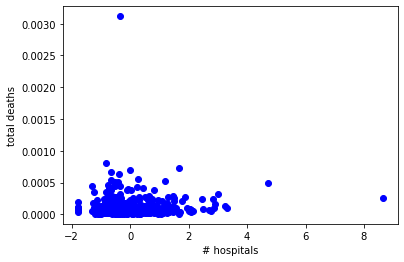

In [53]:
plt.plot(list(combined_data['HospCt']), list(combined_data['normalized_deaths']), 'bo')
plt.xlabel('# hospitals')
plt.ylabel('total deaths')

In [54]:
filter1 = combined_data['Deaths'] > 140
# filter2 = combined_data['deaths'] > 300000
filtered = combined_data.where(filter1)
# filtered.where(filter2, inplace=True)
filtered = filtered.dropna()
filtered.head()

,FIPS,2wk Prior Intra-Mobility,2wk Onset Intra-Mobility,2wk Post Intra-Mobility,2wk Prior Inter-Mobility,2wk Onset Inter-Mobility,2wk Post Inter-Mobility,Density per square mile of land area - Population,Rural-urban_Continuum Code_2013,Percent of adults with less than a high school diploma 2014-18,Percent of adults with a bachelor's degree or higher 2014-18,Unemployment_rate_2018,Med_HH_Income_Percent_of_State_Total_2018,Total_age65plus,Total households!!Average household size,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Nursery school preschool,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Kindergarten,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Elementary school (grades 1-8),SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!High school (grades 9-12),SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!College or graduate school,POP_ESTIMATE_2018,HospCt,NursingCt,Hispanic Population,Black Population,Outbreak Month Temp AVG / F,Time from outbreak to intervention,Time from outbreak to national intervention,Time from national intervention to outbreak,Deaths,normalized_deaths
26,6037,-0.814401,-1.325697,-1.325869,-1.221652,-1.563500,-1.520647,0.407244,-0.882272,2.034368,0.012217,0.518441,-0.640034,-0.562610,1.415432,0.112324,0.134761,-0.479266,-0.254088,0.458226,13.006333,-0.177376,-0.455651,2.299196,-0.371340,-0.143773,1.201661,1.937522,-0.503191,269,2.66191e-05
57,9001,-0.365769,-1.008989,-1.241067,-0.471389,-1.062406,-1.282980,0.140088,0.211454,-0.220424,1.463377,0.016878,0.577870,-0.082298,0.210423,0.704741,-0.076856,0.247120,0.867616,-0.033182,0.622080,-0.778815,-0.223992,0.382086,-0.078347,-1.534655,1.351577,2.408133,-0.503191,178,0.000188595
58,9003,-1.024355,-0.885427,-0.823817,-1.189463,-1.050179,-0.995567,0.069681,-0.882272,-0.139896,0.570355,0.160182,-0.418217,0.180458,-0.489259,-0.128054,-0.303500,-0.447025,0.244575,-0.117576,0.552971,-0.721721,0.332177,0.265979,0.150736,-1.674618,0.527038,0.682560,-0.503191,369,0.000413354
61,9009,-0.833670,-0.928558,-0.854952,-0.932613,-1.041310,-0.994007,0.128728,0.211454,-0.260688,0.300589,0.303486,-0.706998,0.230307,-0.605873,-0.473677,-0.458608,-0.674141,0.194598,0.281568,0.505556,-0.495763,0.376706,0.278112,0.096020,-1.595889,0.751913,1.153171,-0.503191,229,0.000267018
86,12086,-0.321854,-0.421615,-0.413482,-0.814183,-0.872588,-0.862419,0.097535,-0.882272,1.470670,-0.266852,-0.054774,-0.489366,-0.009766,1.570917,0.875990,-0.287304,-0.735582,-0.543987,0.233794,3.079221,-0.469663,3.143709,3.674577,0.329190,1.614512,0.676954,0.839430,-0.503191,207,7.49571e-05


In [55]:
data_arr = combined_data.to_numpy()
X = data_arr[:,2].reshape(1, -1).T
Y = data_arr[:,3].reshape(1, -1).T
reg = lm.LinearRegression().fit(X,Y)
reg.score(X,Y)

0.98423218777324

In [56]:
data_arr = combined_data.to_numpy()
X = data_arr[:,2:10].reshape(8, -1).T
Y = data_arr[:,10].reshape(1, -1).T
reg = lm.LinearRegression().fit(X,Y)
reg.score(X,Y)

0.016726241255972774

In [57]:
# combined_data=combined_data.set_index('FIPS')
combined_data.to_csv('../data/processed/pre_acpca.csv', index=False)
combined_data.shape

(450, 31)

In [58]:
len(combined_data.columns)

31

In [59]:
print(combined_data.columns[0:20])

Index(['FIPS', '2wk Prior Intra-Mobility', '2wk Onset Intra-Mobility',
       '2wk Post Intra-Mobility', '2wk Prior Inter-Mobility',
       '2wk Onset Inter-Mobility', '2wk Post Inter-Mobility',
       'Density per square mile of land area - Population',
       'Rural-urban_Continuum Code_2013',
       'Percent of adults with less than a high school diploma 2014-18',
       'Percent of adults with a bachelor's degree or higher 2014-18',
       'Unemployment_rate_2018', 'Med_HH_Income_Percent_of_State_Total_2018',
       'Total_age65plus', 'Total households!!Average household size',
       'SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Nursery school preschool',
       'SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Kindergarten',
       'SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Elementary school (grades 1-8)',
       'SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!High school (grades 9-12)',
       '

In [60]:
combined_data.head()

,FIPS,2wk Prior Intra-Mobility,2wk Onset Intra-Mobility,2wk Post Intra-Mobility,2wk Prior Inter-Mobility,2wk Onset Inter-Mobility,2wk Post Inter-Mobility,Density per square mile of land area - Population,Rural-urban_Continuum Code_2013,Percent of adults with less than a high school diploma 2014-18,Percent of adults with a bachelor's degree or higher 2014-18,Unemployment_rate_2018,Med_HH_Income_Percent_of_State_Total_2018,Total_age65plus,Total households!!Average household size,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Nursery school preschool,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Kindergarten,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Elementary school (grades 1-8),SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!High school (grades 9-12),SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!College or graduate school,POP_ESTIMATE_2018,HospCt,NursingCt,Hispanic Population,Black Population,Outbreak Month Temp AVG / F,Time from outbreak to intervention,Time from outbreak to national intervention,Time from national intervention to outbreak,Deaths,normalized_deaths
0,1003,2.589641,2.633919,2.930109,1.945899,2.170600,2.617561,-0.239328,1.305179,-0.300952,-0.034295,-0.269730,0.414645,0.883149,-0.217161,-0.312119,-1.607964,0.370213,-0.195225,-1.212098,-0.359016,0.382083,0.091096,-0.663966,-0.373652,1.010922,-0.822207,-0.886143,0.714802,6,2.75202e-05
1,1051,2.616537,2.872442,2.954639,3.883383,4.369864,4.475424,-0.235513,0.211454,0.484199,-0.666851,-0.413033,0.644834,-0.239274,-0.217161,-0.621800,-1.601702,-0.702601,1.155952,-0.618272,-0.543035,2.054335,-0.338005,-0.774031,0.602986,1.798213,-1.721703,-0.886143,2.264974,7,8.54837e-05
2,1073,1.504760,1.746496,1.841919,1.357854,1.500695,1.477280,-0.105273,-0.882272,-0.180160,0.068031,-0.198078,0.197013,-0.087983,-0.450388,0.512166,0.354864,-0.026454,-0.534353,-0.159291,0.237478,0.364953,-0.167607,-0.708818,2.319588,0.757239,0.452080,0.368819,-0.503191,31,4.70196e-05
3,1081,1.711319,1.790704,1.695938,2.248023,2.091171,1.828681,-0.206733,1.305179,-0.341216,0.226170,-0.269730,-0.313586,-0.929576,0.132681,1.036701,-1.497602,-0.060485,-0.343419,3.282705,-0.432119,-0.819174,-0.698036,-0.723703,0.730364,0.800977,0.302164,0.055079,-0.503191,22,0.000134195
4,1089,1.658056,1.603836,1.517825,1.086011,1.039857,0.987019,-0.154306,0.211454,-0.462009,0.933145,-0.341382,0.929430,-0.261015,-1.111199,-0.783442,1.654631,-0.589361,-0.041842,0.463142,-0.158286,-0.492157,-0.190833,-0.635543,0.871903,0.608528,-0.147584,-0.886143,-0.503191,4,1.09135e-05
